<a href="https://colab.research.google.com/github/Antony-gitau/DT8122-Assignment/blob/main/Copy_of_Diffusion_Prac_2023_draft1_DLI_2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<!-- [link text](https://) -->
# **Diffusion Models: Building your own Stable Diffusion**

<img src="https://i.ibb.co/3NgPbzm/diffusion-prac-banner.png" width="100%" />

<a href="https://colab.research.google.com/github/deep-learning-indaba/indaba-pracs-2023/blob/main/practicals/Indaba_2023_Prac_Template.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> [Change colab link to point to prac.]

© Deep Learning Indaba 2023. Apache License 2.0.

**Authors:** Kevin Eloff, Tom Makking, James Allingham

**Reviewers:**

**Introduction:**

Denoising Diffusion Models are a type of generative modelling which serves backbone of recent advances in image synthesis including Dall-E 2, Midjourney, Stable Diffusion and Imagen. These models utilise an iterative denoising process during generation to produce high quality samples. In this practical we will explore the fundamentals of diffusion models, the intuition behind them, and how they work in practice. By the end of the practical, we will have covered all the steps required to train one of these models from scratch!

**Topics:**

Content: <font color='blue'>`Generative Models`</font>, <font color='blue'>`Diffusion`</font>.

Level: <font color='yellow'>`Intermediate`</font> to <font color='red'>`Advanced`</font>.

**Aims/Learning Objectives:**

- Fundamentals and intuition behind diffusion models
- Understanding the maths and formulation requirements
- Experience with diffusion model sampling and various decoding techniques
- How to train diffusion models

**Prerequisites:**

- Familiarity with deep learning
- Python programming
- Experience with probabilistic theory and/or generative modeling.

**Outline:**

[Points that link to each section. Auto-generate following the instructions [here](https://stackoverflow.com/questions/67458990/how-to-automatically-generate-a-table-of-contents-in-colab-notebook).]

**Before you start:**

For this practical, you will need to use a GPU to speed up training. To do this, go to the "Runtime" menu in Colab, select "Change runtime type" and then in the popup menu, choose "GPU" in the "Hardware accelerator" box.

Another important step you need to do. You cannot continue without this!
- Go to `Tools > Settings > Miscellaneous`
- Make sure the options for `Kitty mode` and `Corgi mode` are checked!

**Suggested experience level in this topic:**

| Level         | Experience                            |
| --- | --- |
`Beginner`      | It is my first time being introduced to this work. |
`Intermediate`  | I have done some basic courses/intros on this topic. |
`Advanced`      | I work in this area/topic daily. |

In [ ]:
# @title **Paths to follow:** What is your level of experience in the topics presented in this notebook? (Run Cell)
experience = "advanced" #@param ["beginner", "intermediate", "advanced"]

if experience == "beginner":
    print("""
    Based on your experience, we advise:
    - Skip the coding tasks, rather focus on your understanding
    - Rather run the cells and play with the outputs.

    In terms of content, we suggest you focus on Section 1.1, 1.5, 2.1, and 2.4!
    """)
elif experience == "intermediate":
    print("""
    Based on your experience, we advise:
    - Try out the coding tasks, and try get a high-level understanding of the maths

    In terms of content, we suggest you focus on Section 1.1, 1.5, 2.1, and 2.4!
    """)
elif experience == "advanced":
    print("""
    Based on your experience, we advise going through the whole notebook in detail.

    Feel free to play with the code and come up with your own implementations!
    """)

print("\nNote: This is just a guideline!")

## Installation and Imports

In [3]:
## Install and import anything required. Capture hides the output from the cell.
# @title Install and import required packages. This might take a few minutes. (Run Cell)
#%%capture
!pip install jax==0.3.25 jaxlib==0.3.25 flax transformers ftfy
!pip install diffusers
!pip install invisible_watermark transformers accelerate safetensors
!pip install livelossplot
!apt install texlive-fonts-recommended texlive-fonts-extra cm-super dvipng

import jax
import jax.numpy as jnp
from jax import grad, jit, vmap

import tensorflow_datasets as tfds
import tensorflow as tf
# from einops import rearrange

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import numpy as np
from tqdm.auto import tqdm
from PIL import Image
from livelossplot import PlotLosses
import requests

import flax.linen as nn
import optax

from matplotlib import rc
rc('text', usetex=True)

ERROR: Could not find a version that satisfies the requirement jax==0.3.25 (from versions: none)
ERROR: No matching distribution found for jax==0.3.25
ERROR: Could not find a version that satisfies the requirement diffusers (from versions: none)
ERROR: No matching distribution found for diffusers
ERROR: Could not find a version that satisfies the requirement invisible_watermark (from versions: none)
ERROR: No matching distribution found for invisible_watermark
ERROR: Could not find a version that satisfies the requirement livelossplot (from versions: none)
ERROR: No matching distribution found for livelossplot
E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?


ModuleNotFoundError: No module named 'tensorflow_datasets'

In [ ]:
# @title Check TPU/GPU. (Run Cell)
num_devices = jax.device_count()
device_type = jax.devices()[0].device_kind

print(f"Found {num_devices} JAX devices of type {device_type}.")
# # assert (
# #     "TPU" in device_type or "GPU" in device_type
# # ), "Available device is not a TPU/GPU, please select TPU/GPU from Edit > Notebook settings > Hardware accelerator"

Found 1 JAX devices of type Tesla T4.


In [ ]:
# @title Helper Functions. (Run Cell)

def extract(a, t, x_shape):
    batch_size = x_shape[0]
    out = a[..., t]
    return jnp.reshape(out, (batch_size, *((1,) * (len(x_shape) - 1))))

# 1 Introduction to Image Generation with Diffusion

## 1.1 Example

To start things off, we're going to take a look at a pre-trained image generation model. The goal here is simply to witness the incredible power and capabilities of these models. For this, we will be using StabilityAI's [Stable Diffusion](https://huggingface.co/spaces/stabilityai/stable-diffusion), made available on the HuggingFace diffusers library.

Note: It is important that you use a GPU runtime for this! `Edit > Notebook settings > Hardware accelerator > GPU`

This cell can take a minute or two to run, as it downloads the various model checkpoints. Comment out `%%capture` if you would like to see the download progress.

In [ ]:
%%capture
from diffusers import DiffusionPipeline

# download and load a Stable Diffusion checkpoint
pipe = DiffusionPipeline.from_pretrained("stabilityai/stable-diffusion-xl-base-1.0", torch_dtype=torch.float16, use_safetensors=True, variant="fp16")
pipe.to("cuda")

Now to generate an image! Feel free to modify the prompt to anything you'd like!

  0%|          | 0/50 [00:00<?, ?it/s]

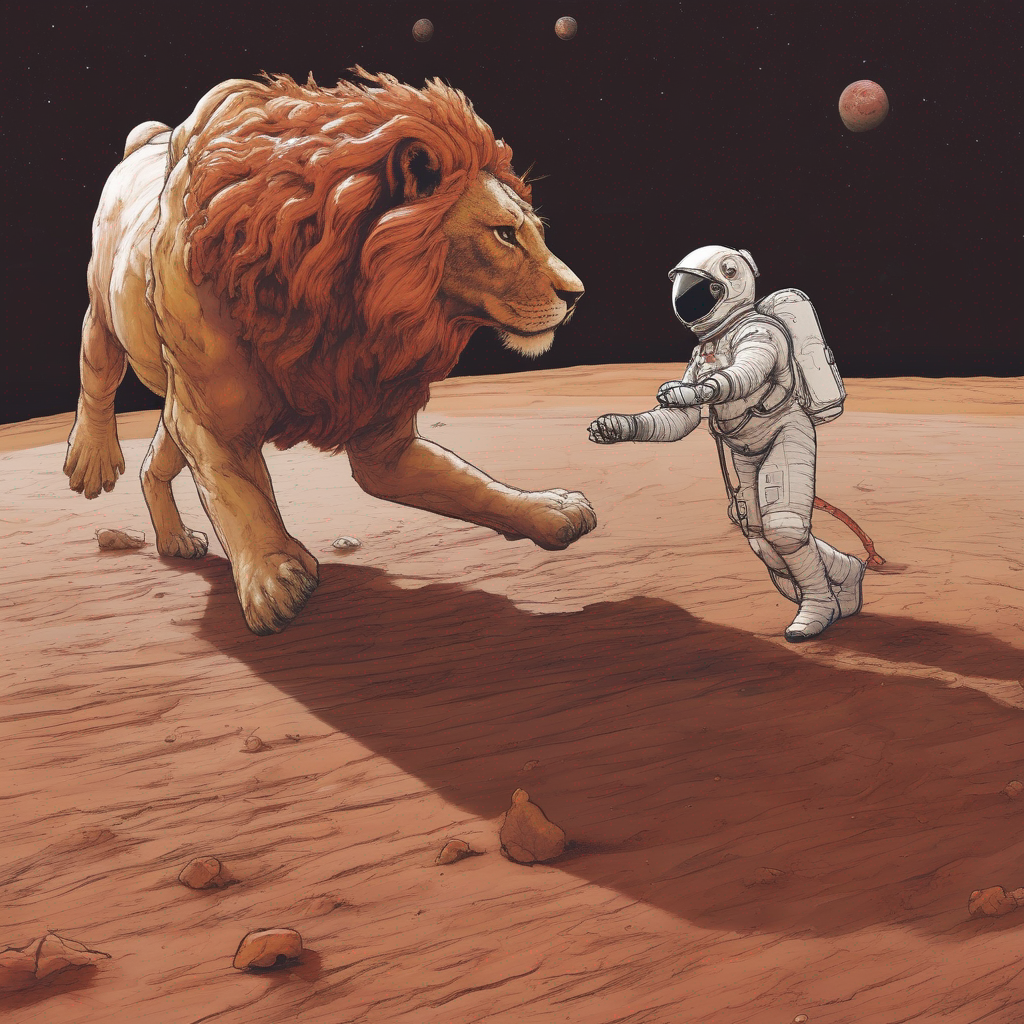

In [ ]:
prompt = "An astronaut riding a lion on Mars"
image = pipe(prompt=prompt).images[0]
image

Now isn't that cool? We were able to take a text prompt and produce a completely new image!

**Group task**
- What sort of cool images can you come up with?
- Can you come up with an image that wouldn't be in the training set? How does the model perform?

**Cleaning up...**

When you're ready to move on, run the cell below. The Stable Diffusion model is quite large (~13GB) and uses up all of our available GPU memory... To continue the practical we will first unload the model and clear our GPU memory. Run the cell below.

In [ ]:
# @title Run this to clear GPU memory. (Run Cell)
import torch
del pipe
del prompt
# del image
torch.cuda.empty_cache()

## 1.2 What are denoising diffusion models?

Denoising Diffusion Models (DDMs), commonly referred to as Diffusion, is a variant of generative modelling. The goal of a generative model is to create new instances of something after being given a few examples. Ideally, we also want these models to generalise. For example, if I have two seperate images of a `lion` and an `astronaut`, can I create a novel image containing both?

Diffusion is the process of iteratively denoising (or refining) a sample starting from random noise. The goal is to generate a novel sample that isn't present in our training data.

From this point forward we will consider diffusion in the context of Images, although diffusion could theoretically be applied to many more domains!

To do this, we define two diffusion process:
- **Forward diffusion**\
  The process of adding noise to an image.\
  We can define this as the distribution $q(\mathbf{x}_{t}|\mathbf{x}_{t-1})$ where $\mathbf{x}_t$ is a slightly noiser version than the image $\mathbf{x}_{t-1}$.
- **Reverse diffusion**\
  The process of removing noise from an image by moving towards some reference.\
  We can define this as the distribution $q(\mathbf{x}_{t-1}|\mathbf{x}_t,\mathbf{x}_0)$ where $\mathbf{x}_0$ is the ground truth image. Here $\mathbf{x}_{t-1}$ is less noisy than $\mathbf{x}_t$ and closer to the target $\mathbf{x}_0$.

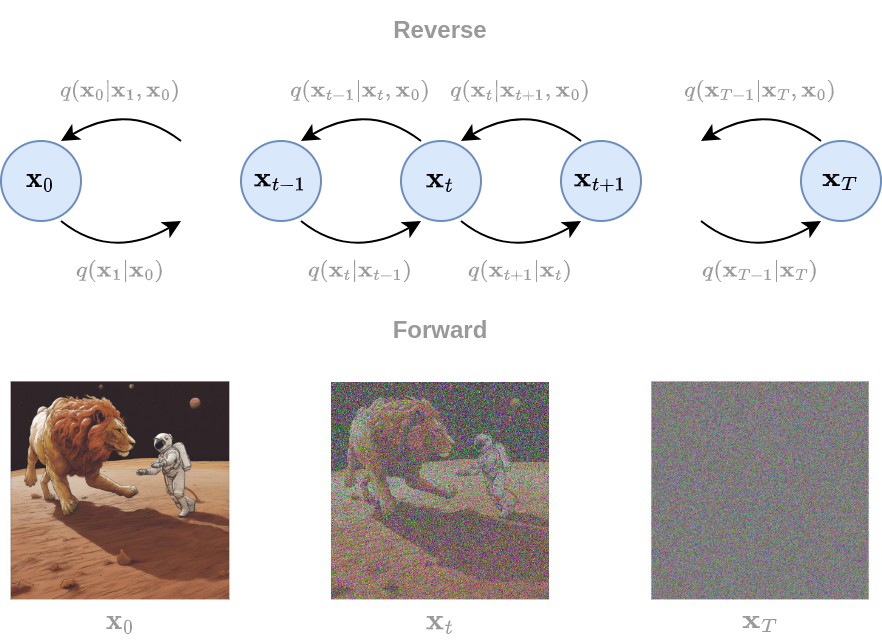

Lets set some terminology for the equations moving forward:

- $\mathbf{x}_0$ is the ground truth image
- $\mathbf{x}_t$ is an image noised by $t$ steps
- $T$ is the maximum number of noising steps

## 1.3 Requirements for Diffusion

The intuition behind Diffusion models is not limited to Images. It can actually be applied to other domains. In general, if you can meet these requirements you should be able to apply Diffusion:

1. The forward noising process must be **reversible**.
  - Given a target $\mathbf{x}_0$, you must be able to reverse the noising process and eventually reconstruct $\mathbf{x}_0$.
  - This process must happen in small increments.
2. At time-step $T$, the data should be **random noise**.
  - After iteratively adding noise for $T$ steps, the result should be something indepenednt of the starting point $\mathbf{x}_0$.
  - This means that (theoretically) any $\mathbf{x}_0$ can become any $\mathbf{x}_T$ with the forward process, and any $\mathbf{x}_T$ can become any $\mathbf{x}_0$ with the reverse process.


## 1.4 Diffusion noise schedule

Before moving on to defining the forward and reverse processes, we first need to define a noise schedule. This is used to schedule how much noise we add at each timestep $t$. For low values of $t$, we only want to add/remove a small amount of noise with the diffusion functions, while at later time-steps we want to add significantly more.

Thus, we define our noise schedule $\{\alpha_t\}_{t=1}^T$ as monotonically decreasing scalar for each time-step $t$ ranging from 1 to 0. We also define $\beta_t = 1 - \alpha_t$. Typically, $\alpha_t$ would use either a linear or cosine decay. The authors of the [Denoising Diffusion Probabilistic Models paper](https://arxiv.org/pdf/2006.11239.pdf), chose a simple linear schedule going from $\beta_1 = 1\times10^{-4}$ to $\beta_T = 0.02$.

**Code task:** implement this linear decay for $\alpha$ using `jax.numpy`.

_hint: look at the documentation for `jnp.linspace`_

In [ ]:
def linear_alpha_schedule(timesteps):
    alpha_start = 0.9999
    alpha_end = 0.98
    return ... # YOUR CODE GOES HERE

In [ ]:
# @title Answer to code task (Try not to peek until you've given it a good try!')
def linear_alpha_schedule(timesteps):
    alpha_start = 0.9999
    alpha_end = 0.98
    return jnp.linspace(alpha_start, alpha_end, timesteps)

In [ ]:
# We can choose this hyperparameter, but 200 seems to be the most common!
T = 200

# Define alpha schedule.
alphas = linear_alpha_schedule(timesteps=T)
betas = 1 - alphas

# Define alpha bar (alpha_cumprod), sqrt alpha bar, and sqrt(1 - alpha bar)
# These will come in handy later!
alphas_cumprod = jnp.cumprod(alphas, axis=0)
sqrt_alphas_cumprod = jnp.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = jnp.sqrt(1.0 - alphas_cumprod)

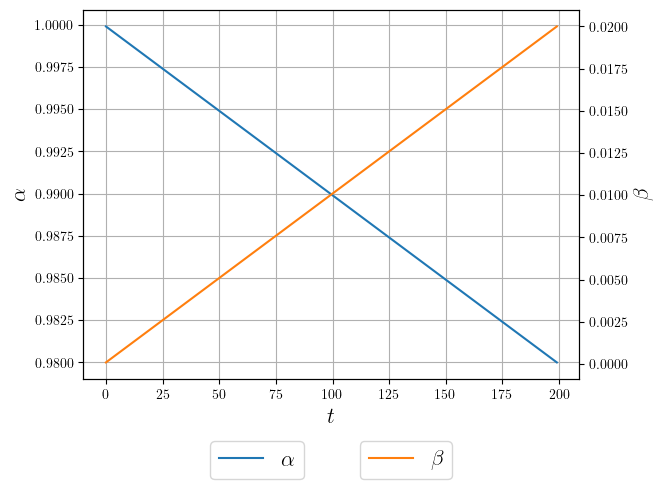

In [ ]:
# @title Plot beta schedule (Run Cell)
fig, ax_a = plt.subplots()

ax_a.plot(alphas)
ax_a.set_xlabel("$t$", fontsize=16)
ax_a.set_ylabel(r'$\alpha$', fontsize=16)
ax_a.grid()

ax_b = ax_a.twinx()
ax_b.plot(betas, c='tab:orange')
ax_b.set_ylabel(r'$\beta$', fontsize=16)
ax_a.legend([r'$\alpha$'], bbox_to_anchor =(0.35,-0.3), loc='lower center', fontsize=16)
ax_b.legend([r'$\beta$'], bbox_to_anchor =(0.65,-0.3), loc='lower center', fontsize=16)
plt.show();

## 1.5 Forward diffusion

Lets now take a closer look at the forward diffusion process. Recall that in this process we want to define the process of iteratively corrupting or noising an image. To do this, we define the distribution $q(\mathbf{x}_{t}|\mathbf{x}_{t-1})$. Given the image at $t-1$, predict a slightly corrupted version for the next time-step $t$.

For images, we can define this **forward** noising distribution as a gaussian paramaterised as follows:

$$
q(\mathbf{x}_t | \mathbf{x}_{t-1}) = \mathcal{N}(\mathbf{x}_t | \sqrt{\alpha_t}\mathbf{x}_{t-1},(1-\alpha_t)\mathbf{I})
$$

where $\mu = \sqrt{\alpha_t}\mathbf{x}_{t-1}$ is the mean, and $\sigma = (1-\alpha_t)$.
We can also sample $\mathbf{x}_t \sim q(\mathbf{x}_t|\mathbf{x}_0)$ directly given $\mathbf{x}_0$, see [Luo C](https://arxiv.org/pdf/2208.11970.pdf) for the derivation.

$$
q(\mathbf{x}_t|\mathbf{x}_0) = \mathcal{N}(\mathbf{x}_t| \sqrt{\bar{\alpha}_t}\mathbf{x}_0,(1-\bar{\alpha}_t)\mathbf{I})
$$

where $\bar{\alpha}_t = \prod^t_{\tau=1}\alpha_\tau$. This will be useful during training as it would be more efficient to directly sample $\mathbf{x}_t$ given $\mathbf{x}_0$.

**Code task:** implement the forward diffusion equation $q(\mathbf{x}_t | \mathbf{x}_{t-1})$

_hint: a property of normal distribution allows us to add the mean and multiply by the variance_

In [ ]:
# Forward diffusion - q(x_t|x_tm1):
def q_sample_one_timestep(x_tm1, t, noise):
    # `noise` is a normal distribution with mean 0 and variance 1

    # Make sure alpha is the correct shape, and allow for batching
    alpha_t = extract(alphas, t, x_tm1.shape)

    return ... # YOUR CODE GOES HERE

# Forward diffusion from x_0 - q(x_t|x_0):
def q_sample(x_start, t, noise):
    # `noise` is a gaussian random normal with mean 0 and variance 1

    # Make sure alpha is the correct shape
    sqrt_alphas_cumprod_t = extract(sqrt_alphas_cumprod, t, x_start.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(sqrt_one_minus_alphas_cumprod, t, x_start.shape)

    return ... # YOUR CODE GOES HERE

In [ ]:
# @title Answer to code task (Try not to peek until you've given it a good try!')
def q_sample_one_timestep(x_tm1, t, noise):
    # `noise` is a gaussian random normal with mean 0 and variance 1

    # Make sure alpha is the correct shape
    alpha_t = extract(alphas, t, x_tm1.shape)

    return jnp.sqrt(alpha_t) * x_tm1 + (1 - alpha_t) * noise

# Forward diffusion - q(x_t|x_0):
def q_sample(x_start, t, noise):
    # `noise` is a gaussian random normal with mean 0 and variance 1

    # Make sure alpha is the correct shape
    sqrt_alphas_cumprod_t = extract(sqrt_alphas_cumprod, t, x_start.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(sqrt_one_minus_alphas_cumprod, t, x_start.shape)

    return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise

Now let's use the image made earlier moving forward. Run the following cell to resize the image to 256x256 so it's easier to work with. If you haven't made an image, we will download the original Lion example.

No image found, downloading the Astro-Lion example!


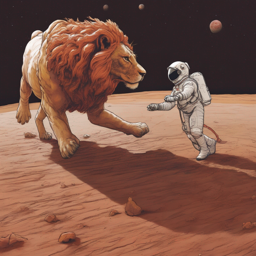

In [ ]:
# @title Resize or download (Run Cell)

if 'image' not in locals() or image is None:
    print("No image found, downloading the Astro-Lion example!")
    url = "https://i.ibb.co/yFMPGph/lion.png"
    image = Image.open(requests.get(url, stream=True).raw)

if image.size[0]>256:
    image = image.resize((256,256))

image

Let's apply the function to the DLI logo and get a list of images at each time-step $t$.

First, we convert the image (an 8 bit integer array with RGB values ranging from 0 to 255) to a normalised image with values ranging from [-1, 1]


**Group task:** Why do we have to normalise the image from -1 to 1?

_hint: think about Gaussian distributions_

In [ ]:
x_0 = jnp.asarray(image, dtype=jnp.float32)[jnp.newaxis, ...]
x_0 = x_0 / 255.0  # normalize the images to [0, 1]
x_0 = (x_0 * 2.0) - 1.0  # convert range to [-1, 1]

key = jax.random.PRNGKey(0)

x_t = x_0
x_t_history = [x_t] # Save the first image

for t in range(1, T+1):
    noise = jax.random.normal(key, x_t.shape)
    x_t = q_sample_one_timestep(x_t, t, noise)
    x_t_history.append(x_t)

Great! Now let's visualise them. Below we display $\mathbf{x}_0$, $\mathbf{x}_3$, $\mathbf{x}_{10}$, $\mathbf{x}_{60}$, $\mathbf{x}_{100}$, and $\mathbf{x}_{200 = T}$ from left to right.

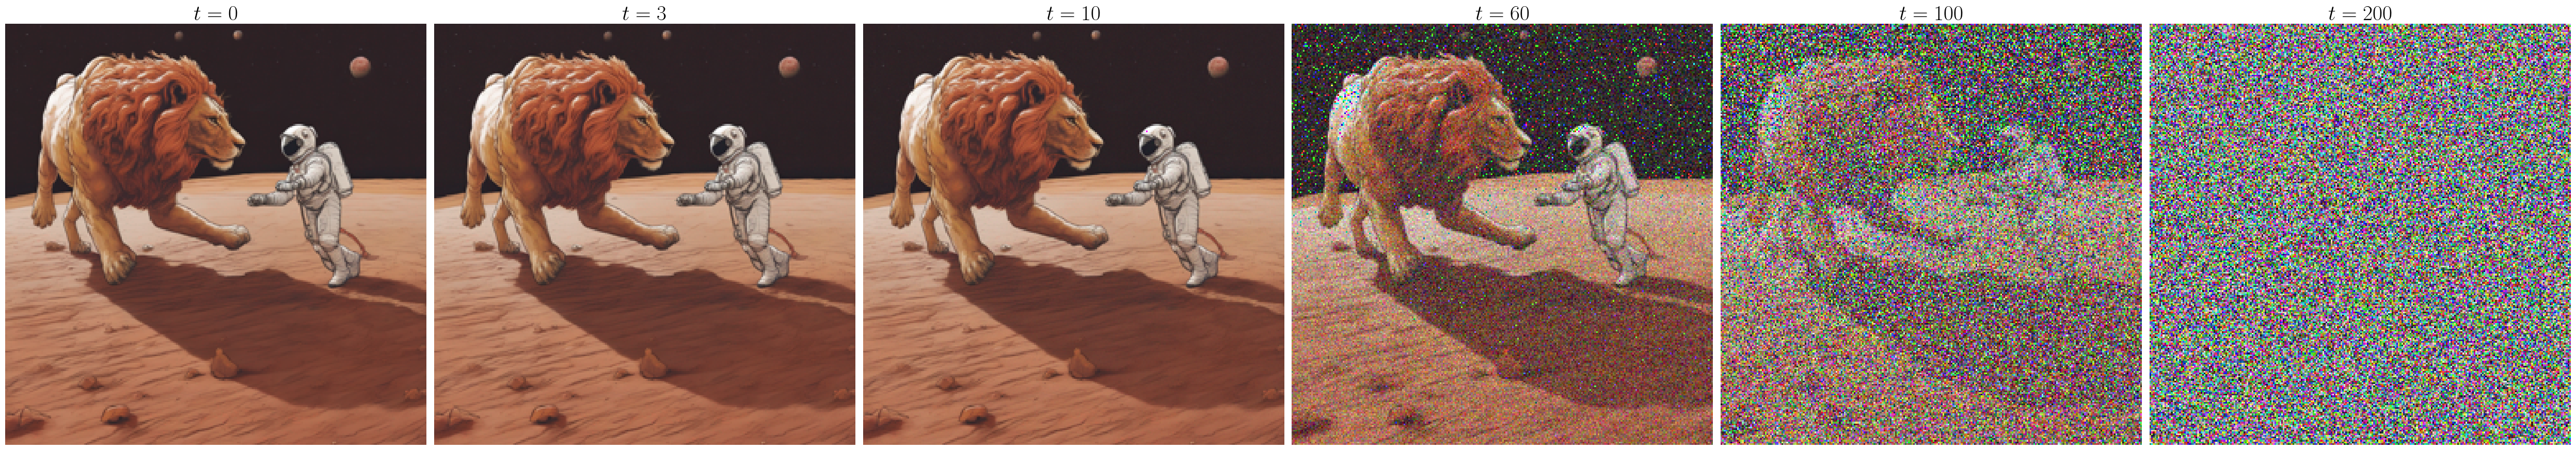

In [ ]:
# @title Diffusion evolution (Run Cell)
ts = [0, 3, 10, 60, 100, 200]

# TODO remove axis ticks

num_cols = len(ts)
fig, axs = plt.subplots(figsize=(50, 50), nrows=1, ncols=num_cols, squeeze=False)
for i, t in enumerate(ts):

    # rescale image back to range 0-255
    noisy_image = (x_t_history[t] + 1.0) / 2.0
    noisy_image = noisy_image * 255.0
    noisy_image = np.array(noisy_image).astype(jnp.uint8)[0]

    ax = axs[0, i]
    ax.imshow(noisy_image)
    ax.set_title(f"$t={t}$", fontsize=30)

    # Remove axis labels and ticks
    ax.axis('off')

plt.tight_layout()

And just like that we have the forward diffusion process down! We're able to take an image and iteratively add noise.

## 1.6 Reverse Diffusion

Now that we have the forward process down, what about the reverse diffusion process? Recall for reverse diffusion we want to remove noise from an image. Given some corrupted image at timestep $t$, and a target image $\mathbf{x}_0$, we want to iteratively move towards $\mathbf{x}_0$.

For images, we can define this **reverse** denoising distribution as a gaussian paramaterised as follows:

$$
q(\mathbf{x}_{t-1}|\mathbf{x}_t, \mathbf{x}_0) = \mathcal{N}\left(\mathbf{x}_{t-1} \Big{|} \frac{1}{1-\bar{\alpha}_t}(\sqrt{\alpha_t}(1-\bar{\alpha}_{t-1})\mathbf{x}_t + \sqrt{\bar{\alpha}_{t-1}}(1-\alpha_t)\mathbf{x}_0), \frac{(1-\alpha_t)(1-\bar{\alpha}_{t-1})}{1-\bar{\alpha_t}}\mathbf{I}\right)
$$

That's a lot to take in! Lets break it up into a seperate mean and covariance. Firstly, the mean is defined as:

$$
\mu_q(\mathbf{x}_t,\mathbf{x}_0) = \frac{1}{1-\bar{\alpha}_t}(\sqrt{\alpha_t}(1-\bar{\alpha}_{t-1})\mathbf{x}_t + \sqrt{\bar{\alpha}_{t-1}}(1-\alpha_t)\mathbf{x}_0)
$$

While this may look complicated, it is essentially an interpolation between $\mathbf{x}_t$ and $\mathbf{x}_0$ with a bunch of normalising constants. The intuition is that for small values of $t$, $\bar{\alpha}_t$ will be large (close to 1). This results in the mean $\mu_q$ being closer to $\mathbf{x}_0$ for small values of $t$, and closer to $\mathbf{x}_t$ for large values of t. See [Luo C](https://arxiv.org/pdf/2208.11970.pdf) for the full derivation.

The covariance on the other hand is simply a function of $t$, and may be defined as:

$$
\Sigma_q(t) = \frac{(1-\alpha_t)(1-\bar{\alpha}_{t-1})}{1-\bar{\alpha_t}}\mathbf{I}
$$

For small values of $t$ the variance is low, but as $t \rightarrow T$, the variance approaches $1$.

In [ ]:
def mu_q(x_t, x_0, t):
    alpha_cumprod_t = extract(alphas_cumprod, t, x_t.shape)
    alpha_cumprod_tm1 = extract(alphas_cumprod, t-1, x_t.shape)
    alpha_t = extract(alphas, t, x_t.shape)

    return (1 / (1 - alpha_cumprod_t)) * (jnp.sqrt(alpha_t)*(1 - alpha_cumprod_tm1)*x_t + jnp.sqrt(alpha_cumprod_tm1)*(1 - alpha_t)*x_0)

def var_q(t, shape):
    alpha_cumprod_t = extract(alphas_cumprod, t, shape)
    alpha_cumprod_tm1 = extract(alphas_cumprod, t-1, shape)
    alpha_t = extract(alphas, t, shape)

    return (1 - alpha_t) * (1 - alpha_cumprod_tm1) / (1 - alpha_cumprod_t)

To help digest these equations, lets try visualie the distributions. In this example we will consider a single scalar value, where $x_0 = 0.5$ and $x_t = 0.1$. We can then plot the gaussian distributions.

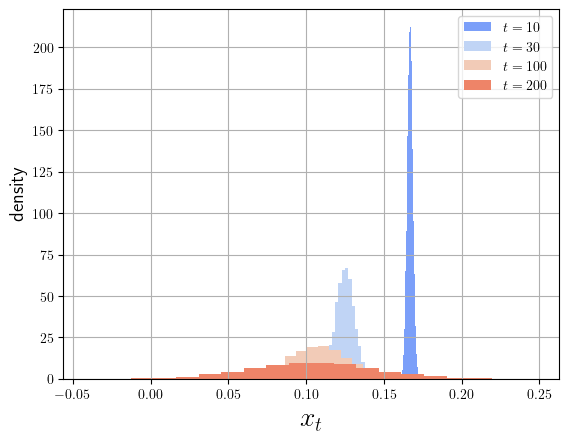

In [ ]:
import seaborn as sns
key = jax.random.PRNGKey(0)

x_t = jnp.array([0.1])
x_0 = jnp.array([0.5])

# Add x_0 and x_t
# Try increase variance
ts = [10, 30, 100, 200]

cmap = sns.color_palette("coolwarm", n_colors=4)

for i,t in enumerate(ts):
    noise = jax.random.normal(key, (10000,))
    mean = mu_q(x_t, x_0, t)
    # We're multiplying by 2 here just to better visualise the distributions
    var = var_q(t, x_t.shape) * 2
    plt.hist(mean + noise * var , bins=20, density=True, color=cmap[i])

plt.xlabel("$x_t$", fontsize=20)
plt.ylabel("density", fontsize=14)
plt.legend([f"$t={t}$" for t in ts])
plt.grid()
plt.show()

## 1.7 Augmenting the reverse process with a model

Great! Now we know how to go both **forward** and **reverse**, but we have a problem. The reverse process is conditioned on $\mathbf{x}_0$, but what will $\mathbf{x}_0$ be in practice if we want to generate novel images? This is where the model comes in! We let the model make a prediction of $\mathbf{x}_0$, referred to as $\mathbf{\hat{x}}_0$, and then use the reverse process as normal.

Concretely, we can now write the distribution $p(\mathbf{x}_{t-1}|\mathbf{x}_t) $ parameterised by a model with weights $\theta$:

$$
p(\mathbf{x}_{t-1}|\mathbf{x}_t) = \mathcal{N}\left(\mathbf{x}_{t-1}; \frac{1}{1-\bar{\alpha}_t}(\sqrt{\alpha_t}(1-\bar{\alpha}_{t-1}\mathbf{x}_t) + \sqrt{\bar{\alpha}_{t-1}}(1-\alpha_t)\hat{\mathbf{x}}_0), \frac{(1-\alpha_t)(1-\bar{\alpha}_{t-1})}{1-\bar{\alpha_t}}\mathbf{I}\right)
$$

where the model predicts a disribution over $\mathbf{\hat{x}}_0$:

$$
p(\hat{\mathbf{x}}_0 | \mathbf{x}_t, \mathbf{c}) = \texttt{Model}(\mathbf{x}_t, \mathbf{c}, \theta)
$$

where $\mathbf{c}$ is an optional conditioning input and $\theta$ are the model parameters. For diffusion models like the one used in Section 1, $\mathbf{c}$ represents an encoding of the text conditioning. Most commonly, a frozen [CLIP](https://github.com/openai/CLIP) text encoder is used for this, as the text embeddings are quite rich and already trained to contain information relevant to images.


# 2. Training and Sampling (generating images)

## 2.1. Putting it all together

Now that we have all the parts, let's put them together to make our own diffusion model! First off, lets start by looking at the training loop.

### Training

The training goes as follows:
- In each **batch**, we sample $\mathbf{c}$, $\mathbf{x}_0$ and $t$
- We sample $\mathbf{x}_t \sim q(\mathbf{x}_t | \mathbf{x}_0)$
- The model predicts $\mathbf{x}_0 \sim p(\hat{\mathbf{x}}_0 | \mathbf{x}_t, \mathbf{c}) = \texttt{Model}(\mathbf{x}_t, \mathbf{c}, \theta)$
- Compute the loss and update the weights

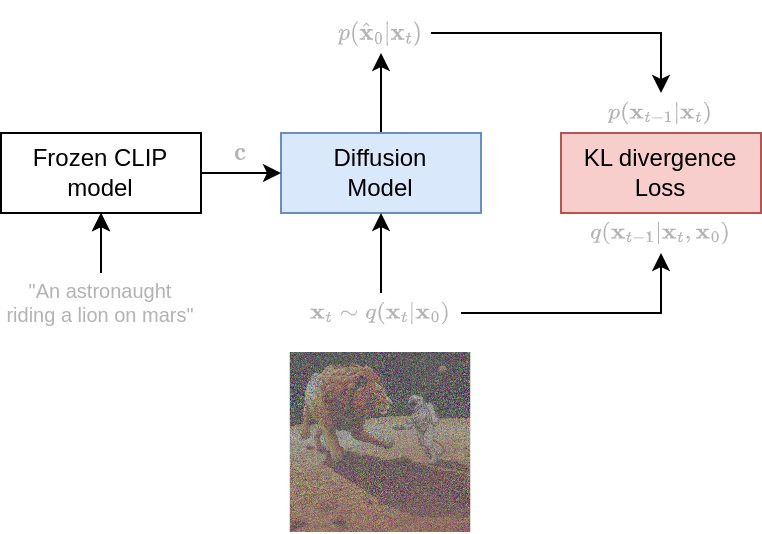

In general, as a loss function we compute the KL-divergence (a metric for comparing the similarity of two distributions) between the ground truth reverse distribution $q(\mathbf{x}_{t-1}|\mathbf{x}_t, \mathbf{x}_0)$ and the models predicted distribution $p(\mathbf{x}_{t-1}|\mathbf{x}_t)$:

$$
\mathcal{L} = \text{KL}(q(\mathbf{x}_{t-1}|\mathbf{x}_t, \mathbf{x}_0)\ ||\ p(\mathbf{x}_{t-1}|\mathbf{x}_t))
$$

## Generation and sampling

The process of generating novel images is relatively straightforward. We simply start with some random sample $\mathbf{x}_T \sim \mathcal{N}(\mathbf{x}_T | \mathbf 0, \mathbf I)$ and iteratively decode until we reach $\mathbf x_0$

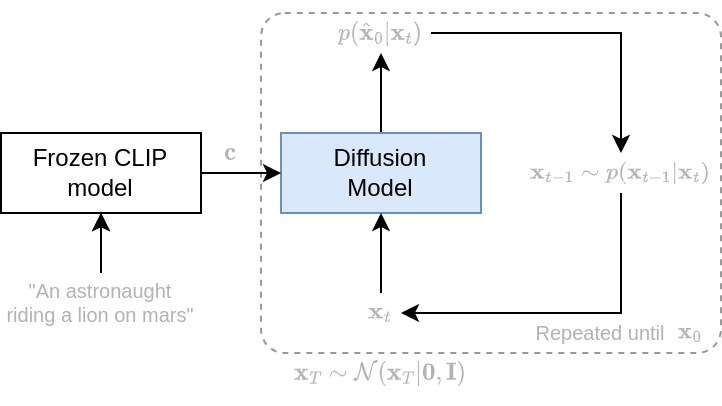

## 2.2 MNIST training data

For this practical, we'll use the MNIST dataset of handwritten digits. While diffusion models are certainly powerful enough to handle more complicated datasets (all of the pictures in the cover image of this notebook were generated using diffusion models!), we'll use MNIST since it allows us to quickly train our models in Google Colab.

Let's load and visualise the dataset:

In [1]:
mnist, info = tfds.load("mnist", split="train", with_info=True)
tfds.show_examples(mnist, info, cols=5)

NameError: name 'tfds' is not defined

Alternatively, we can use the fashion MNIST dataset

In [ ]:
# # homework
# mnist, info = tfds.load("fashion_mnist", split="train", with_info=True)
# tfds.show_examples(mnist, info, cols=5)

## 2.3 Training

Now we'll create a simple data pipeline which will allow us to get batches of correctly formatted data.

We take the following steps:


1. We shuffle our dataset and repeat it so that we don't run out of examples.
2. We batch the data.
3. We take only the images (i.e., we discard the labels) in each batch. This is because we are training an unconditional generative model $p(\mathbf x)$. As an exercise later, you can try training a conditional model, so come back here to keep the labels.
4. We convert the images from `int8` to `float32` format.
5. We change the range of the pixels from $[0, 255]$ to $[-1., 1.]$.
6. We convert from the `tensorflow_datasets` format to a standard python iterator of `jax.numpy` arrays.

In [ ]:
BATCH_SIZE = 128
train_dataset = mnist.shuffle(10 * BATCH_SIZE, seed=0).cache().repeat()
train_dataset = train_dataset.batch(BATCH_SIZE)
train_dataset = train_dataset.map(lambda x: {"image": (tf.cast(x["image"], tf.float32) - 127.5) / 127.5, "label": x["label"]})
train_dataset = iter(tfds.as_numpy(train_dataset))

In [ ]:
batch = next(train_dataset)
batch["image"].shape, batch["label"].shape

((128, 28, 28, 1), (128,))

In [ ]:
class_names = np.arange(10)
class_names

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [ ]:
# class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
#                'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

### Building the NN

The most common choice of NN architecture for image diffusion models is the [U-Net](https://arxiv.org/abs/1505.04597), which gets its name from the U-shape of the architecture as shown in the diagram below.

Like an autoencoder, a U-Net consists of several downsampling stages in which the filter dimension of the image representation is first increased and then the spatial dimensions are downsampled, a bottleneck, and then several upsampling stages in which these downsampling transformations are reversed. The main difference between a U-Net and a standard autoencoder architecture is that at each stage in the upsampling path with include the original representation from the corresponding downsampling stage.

One motivation for using a U-Net rather than a standard autoencoder is that the final representation has information from various *frequencies*. Another is that the ResNet-like connections in the U-Net help with training due to improved gradient propagation.   

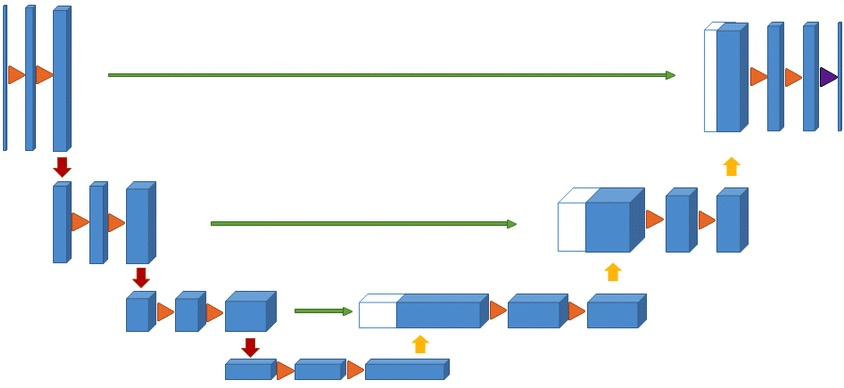


Above, we have a diagram of the U-Net architecture. Here, <font color='orange'>orange</font> arrows indicate ResNet blocks, <font color='red'>red</font> arrows indicate 2D convolutions used for *spatial* downsampling, <font color='goldenrod'>gold</font> arrows indicate 2D transposed convolutions used for *spatial* upsampling, <font color='green'>green</font> arrows indicate a copy and concatenate operation, and the <font color='purple'>purple</font> arrow indicates a final 2D convolution that outputs the correct number of channels. Figure adapted from [here](https://www.researchgate.net/figure/Typical-U-Net-style-architecture-44-The-success-of-this-network-comes-from-the-easy_fig5_343240820).

Let's define our U-Net in `flax`. First, we'll define a number of building blocks, starting with an embedding layer for injecting $t$ into the U-Net.

In [ ]:
class TimeEmbedding(nn.Module):
    dim: int

    @nn.compact
    def __call__(self, time):
        half_dim = self.dim // 2
        embeddings = jnp.log(10000) / (half_dim - 1)
        embeddings = jnp.exp(jnp.arange(half_dim) * -embeddings)
        embeddings = time[:, jnp.newaxis] * embeddings[jnp.newaxis, :]
        embeddings = jnp.concatenate(
            (jnp.sin(embeddings), jnp.cos(embeddings)), axis=-1
        )
        return embeddings

Next we define a ResNet layer consisting of two hidden layers. The ResNet also makes use of the time embedding to make its predictions time dependent. Don't worry too much about the hyperparameters such as the choice activation function and normalisation layer – these details aren't important for understanding how diffusion models work and were just copied from [a PyTorch implementation of diffusion models](https://github.com/lucidrains/denoising-diffusion-pytorch).

In [ ]:
class Block(nn.Module):
    dim_out: int
    groups: int = 8

    @nn.compact
    def __call__(self, x):
        x = nn.Conv(self.dim_out, kernel_size=(3,3), padding=((1, 1), (1, 1)))(x)
        x = nn.GroupNorm(self.groups)(x)
        x = jax.nn.silu(x)
        return x

class ResnetBlock(nn.Module):
    """https://arxiv.org/abs/1512.03385"""
    dim_out: int
    groups: int = 8
    change_dim: bool = False
    add_cond_embed: bool = False

    @nn.compact
    def __call__(self, x, time_emb, cond_emb=None):
        h = Block(self.dim_out, groups=self.groups)(x)

        time_emb = jax.nn.silu(time_emb)
        time_emb = nn.Dense(self.dim_out)(time_emb)
        # We add new axes to the time embedding to for broadcasting.
        h = time_emb[:, jnp.newaxis, jnp.newaxis] + h

        if self.add_cond_embed:
            cond_emb = jax.nn.silu(cond_emb)
            cond_emb = nn.Dense(self.dim_out)(cond_emb)
            h = cond_emb[:, jnp.newaxis, jnp.newaxis] + h

        h = Block(self.dim_out, groups=self.groups)(h)
        if self.change_dim:
            return h + nn.Conv(self.dim_out, kernel_size=(1,1), padding=((0, 0),(0, 0)))(x)
        return h + x

Next, we define the up and down sampling operations.

In [ ]:
def SpatialUpsample(dim):
    return nn.ConvTranspose(dim, kernel_size=(4,4), strides=(2,2))


def SpatialDownsample(dim):
    return nn.Conv(dim, kernel_size=(4,4), strides=(2,2), padding=((1, 1), (1, 1)))

Finally, we are ready to define our U-Net!

**Code task:** In the `ConditionedUnet` definition below, the downsampling path is fully defined, but the upsampling path is missing. Fill in the missing code.

_hint: Take a look at the spatial downsampling loop and use `h.pop()`!_

In [ ]:
class ConditionedUnet(nn.Module):
    dim: int
    dim_mults: tuple = (1,2,4)
    channels: int = 3
    resnet_block_groups: int = 7
    add_cond_embed: bool = True
    num_cond_embeddings: int = 10

    training: bool = True

    @nn.compact
    def __call__(self, x, time, cond=None, cond_mask=None):
        init_dim = self.dim // 3 * 2
        time_dim = self.dim * 4
        cond_dim = self.dim * 4

        x = nn.Conv(init_dim, kernel_size=(7,7), padding=((3, 3), (3, 3)))(x)

        t = TimeEmbedding(self.dim)(time)
        t = nn.Dense(time_dim)(t)
        t = jax.nn.gelu(t)
        t = nn.Dense(time_dim)(t)

        if self.add_cond_embed and cond is not None:
            c = nn.Embed(self.num_cond_embeddings, cond_dim)(cond)
            if cond_mask is not None:
                c = c * cond_mask[:, jnp.newaxis]
        else:
            c = jnp.zeros((x.shape[0], cond_dim))

        h = []

        # downsample
        dims = list(map(lambda m: self.dim * m, self.dim_mults))

        for ind, stage_dim in enumerate(dims):
            is_last = ind >= len(dims) - 1

            x = ResnetBlock(stage_dim, groups=self.resnet_block_groups, add_cond_embed=self.add_cond_embed, change_dim=True)(x, t, c)
            x = ResnetBlock(stage_dim, groups=self.resnet_block_groups, add_cond_embed=self.add_cond_embed)(x, t, c)
            h.append(x)
            x = (SpatialDownsample(stage_dim) if not is_last else lambda x: x)(x)

        # bottleneck
        mid_dim = dims[-1]
        x = ResnetBlock(mid_dim, groups=self.resnet_block_groups, add_cond_embed=self.add_cond_embed)(x, t, c)
        x = ResnetBlock(mid_dim, groups=self.resnet_block_groups, add_cond_embed=self.add_cond_embed)(x, t, c)

        # upsample
        rev_dims = list(reversed(dims))
        for ind, stage_dim in enumerate(rev_dims):
            is_last = ind >= len(dims) - 1

            # YOUR SOLUTION GOES HERE
            # Refer to the U-Net diagram if you need help.

        x = ResnetBlock(self.dim, groups=self.resnet_block_groups, add_cond_embed=self.add_cond_embed)(x, t, c)
        return nn.Conv(self.channels, kernel_size=(1,1), padding=((0, 0), (0, 0)))(x)

In [ ]:
# @title Answer to code task (Try not to peek until you've given it a good try!)

class ConditionedUnet(nn.Module):
    dim: int
    dim_mults: tuple = (1,2,4)
    channels: int = 3
    resnet_block_groups: int = 7
    add_cond_embed: bool = True
    num_cond_embeddings: int = 10

    training: bool = True

    @nn.compact
    def __call__(self, x, time, cond=None, cond_mask=None):
        init_dim = self.dim // 3 * 2
        time_dim = self.dim * 4
        cond_dim = self.dim * 4

        x = nn.Conv(init_dim, kernel_size=(7,7), padding=((3, 3), (3, 3)))(x)

        t = TimeEmbedding(self.dim)(time)
        t = nn.Dense(time_dim)(t)
        t = jax.nn.gelu(t)
        t = nn.Dense(time_dim)(t)

        if self.add_cond_embed and cond is not None:
            c = nn.Embed(self.num_cond_embeddings, cond_dim)(cond)
            if cond_mask is not None:
                c = c * cond_mask[:, jnp.newaxis]
        else:
            c = jnp.zeros((x.shape[0], cond_dim))

        h = []
        # downsample
        dims = list(map(lambda m: self.dim * m, self.dim_mults))

        for ind, stage_dim in enumerate(dims):
            is_last = ind >= len(dims) - 1

            x = ResnetBlock(stage_dim, groups=self.resnet_block_groups, add_cond_embed=self.add_cond_embed, change_dim=True)(x, t, c)
            x = ResnetBlock(stage_dim, groups=self.resnet_block_groups, add_cond_embed=self.add_cond_embed)(x, t, c)
            h.append(x)
            x = (SpatialDownsample(stage_dim) if not is_last else lambda x: x)(x)

        # bottleneck
        mid_dim = dims[-1]
        x = ResnetBlock(mid_dim, groups=self.resnet_block_groups, add_cond_embed=self.add_cond_embed)(x, t, c)
        x = ResnetBlock(mid_dim, groups=self.resnet_block_groups, add_cond_embed=self.add_cond_embed)(x, t, c)

        # upsample
        rev_dims = list(reversed(dims))
        for ind, stage_dim in enumerate(rev_dims):
            is_last = ind >= len(dims) - 1

            x = jnp.concatenate((x, h.pop()), axis=-1)
            x = ResnetBlock(stage_dim, groups=self.resnet_block_groups, add_cond_embed=self.add_cond_embed, change_dim=True)(x, t, c)
            x = ResnetBlock(stage_dim, groups=self.resnet_block_groups, add_cond_embed=self.add_cond_embed)(x, t, c)
            x = (SpatialUpsample(stage_dim) if not is_last else lambda x: x)(x)

        x = ResnetBlock(self.dim, groups=self.resnet_block_groups, add_cond_embed=self.add_cond_embed)(x, t, c)
        return nn.Conv(self.channels, kernel_size=(1,1), padding=((0, 0), (0, 0)))(x)

### Initialising our Unet model and Adam optimiser

In [ ]:
LR = 5e-4
IMAGE_SIZE = 28
CHANNELS = 1
COND_CLASSES = 10
COND_DROPOUT_PROB = 0.2

In [ ]:
model = ConditionedUnet(dim=IMAGE_SIZE, channels=CHANNELS, num_cond_embeddings=COND_CLASSES)

In [ ]:
init_rng = jax.random.PRNGKey(42)
dummy_input = jnp.ones((1, IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
variables = model.init(
  init_rng,
  dummy_input, jnp.array([0]), jnp.array([0]) # <== inputs
)
params = variables["params"]

optimiser = optax.adam(LR)
opt_state = optimiser.init(params)

### The Loss Function

Recall, the loss is calculated as the KL divergence between the two reverse process distributions. In practice, the KL divergence of these two distributions may be realised by the L2 loss or MSE between $\mathbf{\hat{x}}_0$ and $\mathbf{x}_0$ for continuous data. See [Luo C](https://arxiv.org/pdf/2208.11970.pdf) for the full derivation.

Let's implement the MSE loss in `jax`


**Code task:** Complete the loss training step below
- Add code to calculate $\mathbf{x}_t$ given $\mathbf{x}_0$ and $t$
- Add code to perform the loss calculation: $\mathcal{L} = \frac{1}{n}\sum(\mathbf{x}_0 - \hat{\mathbf{x}}_0 )^2$
- Add code to update the parameters of the model given the gradients in `grads`. \
(remember, the optimiser has already been initialised above)

_hint: use the `q_sample` function defined earlier._

In [ ]:
@jax.jit
def train_step(params, opt_state, x_0, t, c, c_mask, noise):
    x_t = ... # YOUR CODE GOES HERE

    @jax.jit
    def loss_fn(params):
        x_0_hat = model.apply(
            {'params': params},
            x_t, t, c, c_mask # <== inputs
        )
        loss = ... # YOUR CODE GOES HERE
        return loss

    loss, grads = jax.value_and_grad(loss_fn)(params)
    # YOUR CODE GOES HERE
    # Hint: Refer to optax docs if you need help!

    return params, opt_state, loss

In [ ]:
# @title Answer to code task (Try not to peek until you've given it a good try!)

@jax.jit
def train_step(params, opt_state, x_0, t, c, c_mask, noise):
    x_t = q_sample(x_start=x_0, t=t, noise=noise)

    @jax.jit
    def loss_fn(params):
        x_0_hat = model.apply(
            {'params': params},
            x_t, t, c, c_mask # <== inputs
        )
        loss = jnp.mean((x_0 - x_0_hat) ** 2)
        return loss

    loss, grads = jax.value_and_grad(loss_fn)(params)
    updates, opt_state = optimiser.update(grads, opt_state)
    params = optax.apply_updates(params, updates)

    return params, opt_state, loss

### Training time!

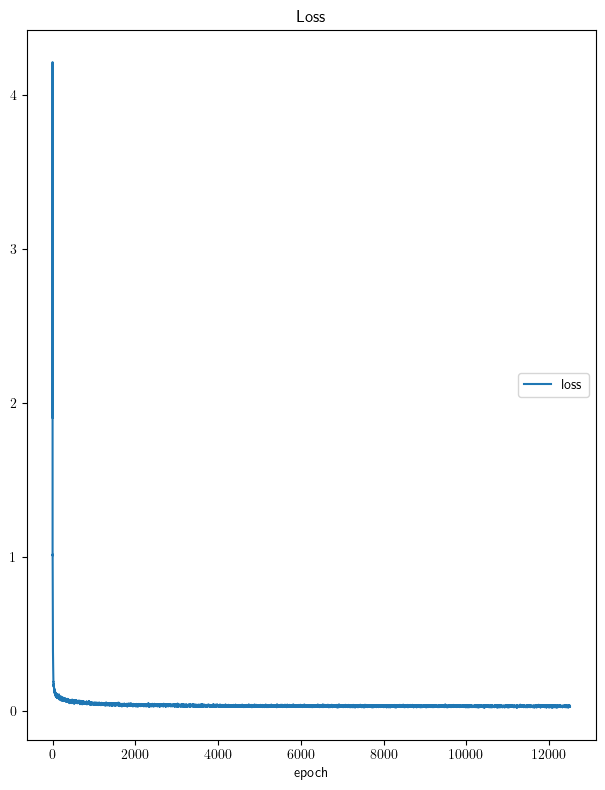

Loss
	loss             	 (min:    0.021, max:    4.211, cur:    0.032)
CPU times: user 32min 39s, sys: 5min 31s, total: 38min 10s
Wall time: 33min 24s


In [ ]:
%%time
plotlosses = PlotLosses()

MAX_STEPS = 2501*5
key = jax.random.PRNGKey(42)

best_loss = jnp.inf
for step in range(MAX_STEPS):
    key, noise_key, time_key, cond_drop_key = jax.random.split(key, num=4)

    batch = next(train_dataset)
    x_0 = batch['image']
    c = batch['label']
    batch_size = x_0.shape[0]

    t = jax.random.randint(time_key, (batch_size,), 0, T)
    noise = jax.random.normal(noise_key, x_0.shape)

    # A mask of zeros and ones to drop conditioning
    p = jnp.array([COND_DROPOUT_PROB, 1-COND_DROPOUT_PROB])
    c_mask = jax.random.choice(cond_drop_key, 2, shape=(batch_size,), replace=True, p=p)

    params, opt_state, loss = train_step(params, opt_state, x_0, t, c, c_mask, noise)

    if loss < best_loss:
        best_params = params
        best_loss = loss

    plotlosses.update({"loss": loss})
    if step % 50 == 0:
        plotlosses.send()

## 2.4 Sampling novel images

Lets write the code to perform the image generation loop and generates a few samples

**Code task:** Complete the code for a single step of sampling using the distribution $q(\mathbf x_{t-1} | \mathbf x_{t})$

_hint: use the functions created earlier in Section 1.6 (`mu_q` and `var_q`)._

In [ ]:
from functools import partial

@partial(jax.jit, static_argnums=5)
def sample_iteration(params, key, x, t, c, add_noise=True):
    # Use our model to predict x_0
    x_0_hat = model.apply({'params': params}, x, t, c)

    # mean 0, variance 1
    noise = jax.random.normal(key, x.shape)

    if add_noise:
        mean = ... # YOUR CODE GOES HERE
        var = ... # YOUR CODE GOES HERE
        x_tm1 = ... # YOUR CODE GOES HERE
    else:
        # Don't sample the final timestep (t=0)
        x_tm1 = x_0_hat

    return x_tm1, x_0_hat

In [ ]:
# @title Answer to code task (Try not to peek until you've given it a good try!)

from functools import partial

@partial(jax.jit, static_argnums=5)
def sample_iteration(params, key, x, t, c, add_noise=True):
    # Use our model to predict x_0
    x_0_hat = model.apply({'params': params}, x, t, c)

    noise = jax.random.normal(key, x.shape)

    if add_noise:
        mean = mu_q(x, x_0_hat, t)
        var = var_q(t, x.shape)
        x_tm1 = mean + noise * var
    else:
        x_tm1 = x_0_hat

    return x_tm1, x_0_hat

Now let's use your function to generate some samples! This function loops through $t$ from $T$ to $0$ and stores all the images of $\mathbf{x}_t$ and $\hat{\mathbf{x}}_0$.

In [ ]:
def sample(params, key, image_size, batch_size=16, channels=3, labels=None):
    shape = (batch_size, image_size, image_size, channels)

    img_key, key = jax.random.split(key, num=2)
    # start from pure noise (for each example in the batch)
    img = jax.random.normal(img_key, shape)
    imgs = []
    model_imgs = []

    for i in tqdm(
        reversed(range(0, T)), desc="sampling loop time step", total=T
    ):
        noise_key, key = jax.random.split(key, num=2)
        img, x_0_hat = sample_iteration(
            params, noise_key, img, jnp.full((batch_size,), i), labels, i != 0
        )
        imgs.append(img)
        model_imgs.append(x_0_hat)

    return imgs, model_imgs

In [ ]:
samples, model_samples = sample(best_params, key, IMAGE_SIZE, 25, CHANNELS)

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

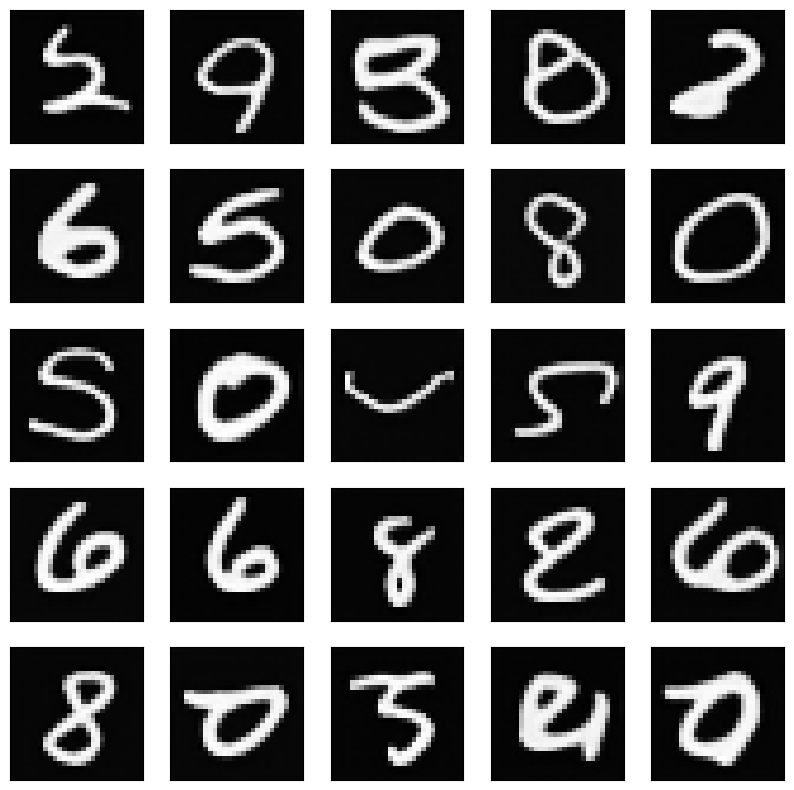

In [ ]:
# @title Show unconditional samples (Run Cell)
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    img_index = np.random.randint(0, 50000)
    plt.imshow(samples[-1][i][:, :, 0], cmap='gray')

Let's try condition the model outputs and take a look at the samples generated:

In [ ]:
label = 4
labels = jnp.full((25,), label)
samples, model_samples = sample(best_params, key, IMAGE_SIZE, labels.shape[0], CHANNELS, labels)

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

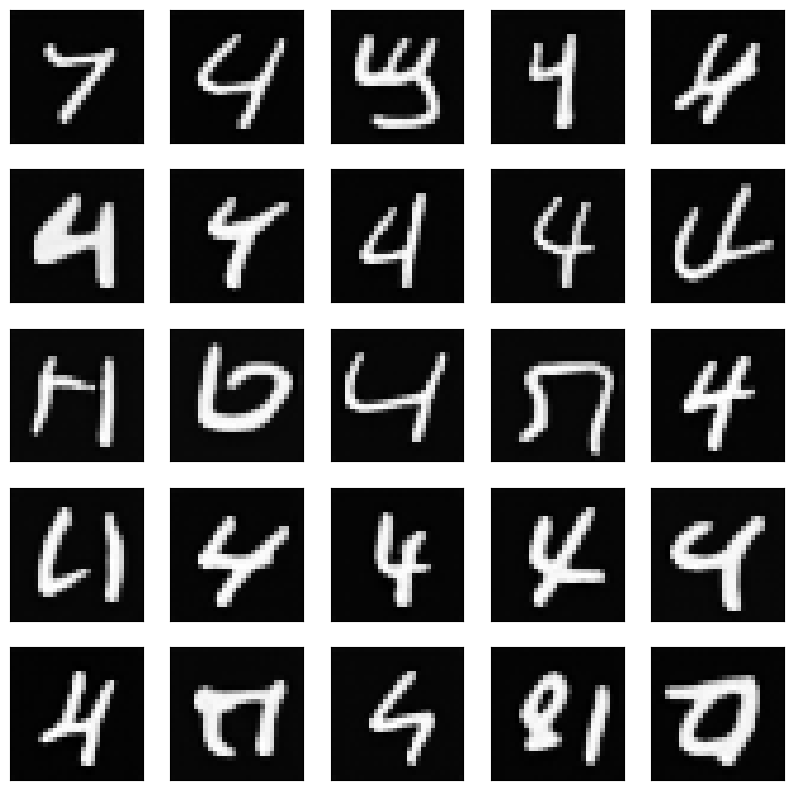

In [ ]:
# @title Show conditional samples (Run Cell)
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    img_index = np.random.randint(0, 50000)
    plt.imshow(samples[-1][i][:, :, 0], cmap='gray')

And just like that, we're able to generate new digits.

Now let's take a closer look at what the model is doing at each timestep. In this example we will show the input to the model at $\mathbf{x}_t$ and the model's prediction $\hat{\mathbf{x}}_0$ for $t= [200,151,101,51,1]$.

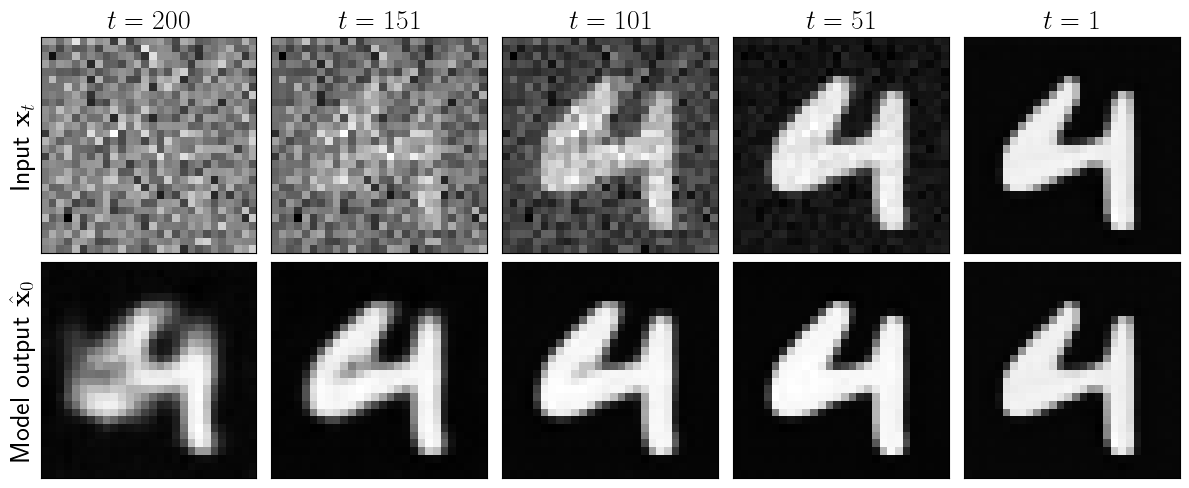

In [ ]:
# @title Show decoding (Run Cell)
sample_index = 5  # @param

# Use plt latex math mode

fig, ax = plt.subplots(figsize=(12,5), nrows=2, ncols=5)
# plt.xticks([])

for i,t in enumerate([0, 49, 99, 149, 199]):
    # ax[0,i].subplot(2, 5, i + 1)
    ax[0,i].set_xticks([])
    ax[0,i].set_yticks([])
    # ax[0,i].set_grid(False)
    ax[1,i].set_xticks([])
    ax[1,i].set_yticks([])
    # ax[1,i].set_grid(False)

    # img_index = np.random.randint(0, 50000)
    ax[0,i].imshow(samples[t][sample_index][:, :, 0], cmap='gray', )
    # ax[0,i].set_title(r"$\mathbf{x}_{" + f"{T-t}" + r"}$")
    ax[0,i].set_title(f"$t = {T-t}$", fontsize=20)
    ax[1,i].imshow(model_samples[t][sample_index][:, :, 0], cmap='gray')
    # ax[1,i].set_title(r"$\hat{\textbf{x}}_0 @ t={" + f"{T-t}" + r"}$")

ax[0,0].set_ylabel(r"Input $\mathbf{x}_t$", fontsize=20)
ax[1,0].set_ylabel(r"Model output $\hat{\mathbf{x}}_0$", fontsize=20)
plt.tight_layout()

Let's also animate the process!

In [ ]:
# @title Animate diffusion (Run Cell)
sample_index = 5  # @param

# Look into adding x_0 next to x_t

fig = plt.figure()
ims = []
for i in range(T):
    im = plt.imshow(samples[i][sample_index][:, :, 0], animated=True, cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    ims.append([im])

animate = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=5000)
plt.close()

HTML(animate.to_html5_video())

## 2.5 Decoding techniques [homework] [TODO]

- Classifier-free guidance
- Inpainting

## Conclusion
**Summary:**

In this practical, we took a look at an exciting new variant of generative modelling: diffusion. We explored the two processes used to train and generate with these models, the forward noising process and the reverse denoising process.

**Next Steps:**

As next steps, we encourage you to try play around with various decoding techniques, especially inpainting.

If you would like a more in-depth look at the probablisitc theory, we encourage you to go through last year's deep generative models practical by James Allingham \
https://github.com/deep-learning-indaba/indaba-pracs-2022/blob/main/practicals/deep_generative_models.ipynb
- This practical takes a deep dive into the probabilistic theory behind diffusion and includes a practical implementation in Jax and Haiku


<!-- **Appendix:**

[Anything (probably math heavy stuff) we don't have space for in the main practical sections.] -->

**References:**

- Understanding Diffusion Models: A Unified Perspective; Luo C. \
https://arxiv.org/pdf/2208.11970.pdf

- RePaint: Inpainting using denoising diffusion probabilistic models; Lugmayr, A., Danelljan, M., Romero, A., Yu, F., Timofte, R., Gool, L.V. \
https://arxiv.org/abs/2201.09865

- TransFusion: Transcribing Speech with Multinomial Diffusion; Baas M., Eloff K.M., Kamper H. \
https://arxiv.org/abs/2210.07677

For other practicals from the Deep Learning Indaba, please visit [here](https://github.com/deep-learning-indaba/indaba-pracs-2023).

## Feedback

Please provide feedback that we can use to improve our practicals in the future.

In [ ]:
# @title Generate Feedback Form. (Run Cell)
from IPython.display import HTML

HTML(
    """
<iframe
	src="https://forms.gle/Cg9aoa7czoZCYqxF7",
  width="80%"
	height="1200px" >
	Loading...
</iframe>
"""
)

<img src="https://baobab.deeplearningindaba.com/static/media/indaba-logo-dark.d5a6196d.png" width="50%" />